# Personal Health Tracker
 CNN for X-ray Images


In [ ]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import classification_report

# Dataset paths
train_dir = "/content/heart_disease/chest_xray/chest_xray/train"
val_dir = "/content/heart_disease/chest_xray/chest_xray/val"
test_dir = "/content/heart_disease/chest_xray/chest_xray/test"

print(train_dir, val_dir, test_dir)

# Image preprocessing and augmentation
img_size = (224, 224)
batch_size = 32

# Training data augmentation
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.10,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Validation data (only rescaling)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Test data (only rescaling, no shuffle)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze convolutional layers to retain learned features
base_model.trainable = False

# Add custom CNN head for classification
x = base_model.output
x = GlobalAveragePooling2D(name="cnn_gap")(x)
x = Dropout(0.3, name="cnn_dropout")(x)

# Output layer for binary classification
output = Dense(1, activation='sigmoid', name="cnn_output")(x)

# Full CNN model
cnn_model = Model(inputs=base_model.input, outputs=output, name="CNN_Model")

# Compile model
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
cnn_model.summary()

# Train CNN model
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# Evaluate on test set
test_loss, test_acc = cnn_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save full CNN model
cnn_model.save("heart_cnn_model.h5")
print("Full CNN model saved.")

# Extract CNN embedding for fusion
embedding_layer = base_model.output  # shape: (None, 7, 7, 1280)

pooled_features = GlobalAveragePooling2D(name="cnn_embedding")(embedding_layer)

cnn_embedding_model = Model(
    inputs=base_model.input,
    outputs=pooled_features,
    name="CNN_Embedding_Model"
)

cnn_embedding_model.save("cnn_embedding_model.h5")
print("CNN embedding saved. Ready for fusion.")
print("CNN embedding shape:", cnn_embedding_model.output_shape)



In [ ]:
import numpy as np

pred_probs = model.predict(test_gen)
pred_labels = (pred_probs > 0.5).astype(int)


20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_gen.classes, pred_labels))


              precision    recall  f1-score   support

           0       0.98      0.54      0.70       234
           1       0.78      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624



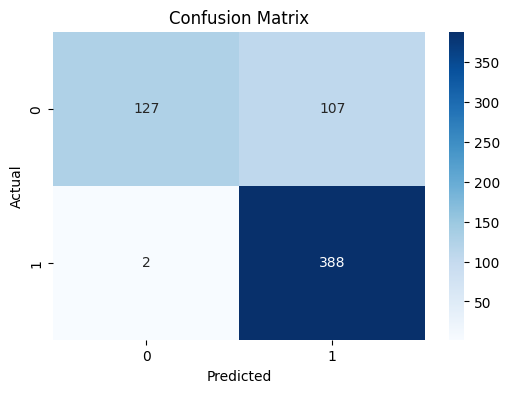

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_gen.classes, pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


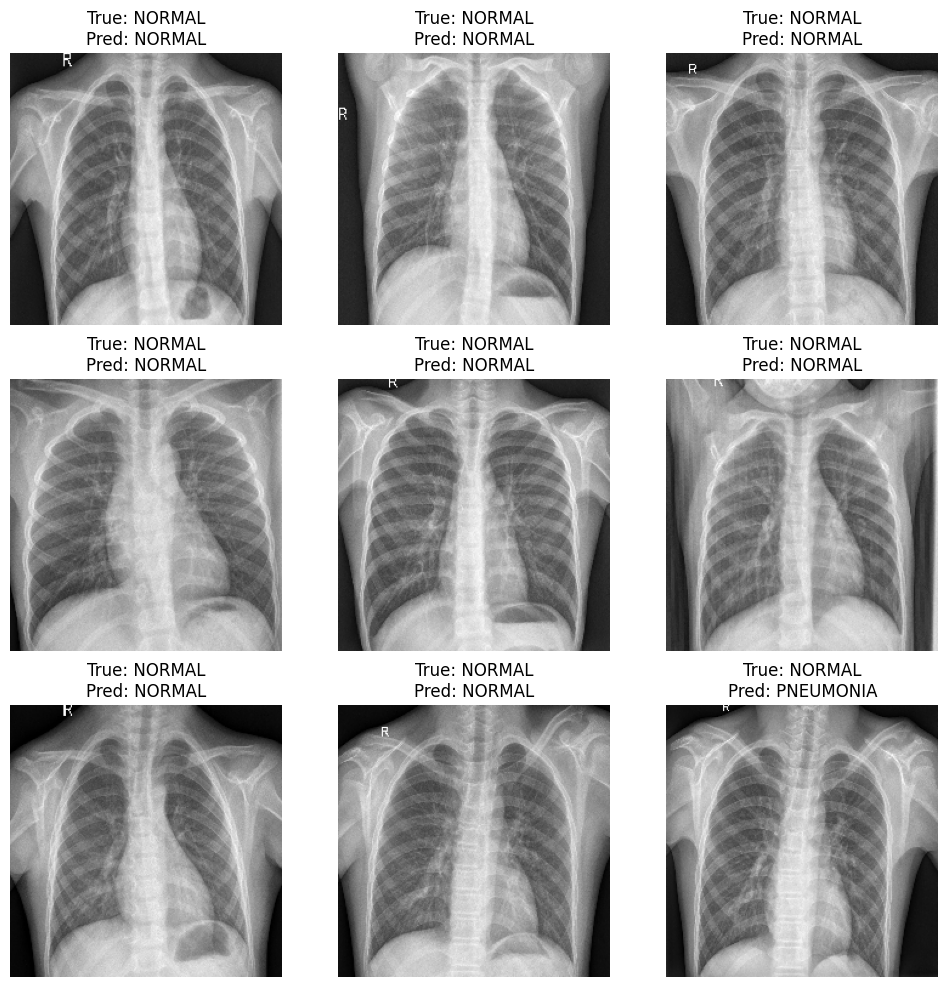

In [ ]:
import matplotlib.pyplot as plt

class_names = list(test_gen.class_indices.keys())  # ['NORMAL', 'CARDIOMEGALY'] etc.

# Take 9 images from test set
test_gen.reset()
images, labels = next(test_gen)

plt.figure(figsize=(12,12))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i]
    true_label = class_names[int(labels[i])]

    pred_prob = model.predict(img.reshape(1,224,224,3))[0][0]
    predicted_label = class_names[int(pred_prob > 0.5)]

    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis("off")

plt.show()
